# Notebook 3 — The same idea in PyTorch (autodiff + SGD)

This notebook repeats the function approximation task, but now we use **PyTorch**:
- You define the model (layers) using `torch.nn`.
- You define the loss using `torch.nn` losses.
- PyTorch computes gradients automatically via **autodiff** (`loss.backward()`).
- You update parameters using **SGD** (`torch.optim.SGD`).

Goal: learn the basic PyTorch training loop you will reuse in most ML projects.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

plt.rcParams["figure.figsize"] = (10, 6)

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 1. Dataset
Same target function as Notebook 2.


In [2]:
def target_function_np(x):
    return np.sin(x) * x**3 - np.tanh(x)

# Training grid
x_np = np.linspace(-np.pi, np.pi, 100).reshape(-1, 1).astype(np.float32)
y_np = target_function_np(x_np).astype(np.float32)

# Convert to torch tensors
x_train = torch.from_numpy(x_np).to(device)
y_train = torch.from_numpy(y_np).to(device)

print("x_train:", x_train.shape, "y_train:", y_train.shape)


x_train: torch.Size([100, 1]) y_train: torch.Size([100, 1])


## 2. Define the model
A 1-hidden-layer network:
- `Linear(1 -> hidden_dim)`
- `Tanh()`
- `Linear(hidden_dim -> 1)`

This is conceptually the same as the NumPy model, but much easier to train because gradients are automatic.


In [3]:
class TorchMLP(nn.Module):
    def __init__(self, hidden_dim=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

model = TorchMLP(hidden_dim=14).to(device)
print(model)


TorchMLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=14, bias=True)
    (1): Tanh()
    (2): Linear(in_features=14, out_features=1, bias=True)
  )
)


## 3. Loss + optimizer (SGD)
We use:
- Mean Squared Error (MSE)
- Stochastic Gradient Descent (SGD)

Even though we use *full batch* here for simplicity, it is still called SGD in PyTorch.


In [4]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Optional: learning rate schedule could be added later


## 4. Training loop
Key steps:
1. `optimizer.zero_grad()` clears old gradients
2. forward pass → predictions
3. compute loss
4. `loss.backward()` computes gradients
5. `optimizer.step()` updates parameters


In [5]:
epochs = 5000
print_every = 500

loss_history = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % print_every == 0:
        print(f"Epoch {epoch:5d} | Loss = {loss.item():.6f}")


Epoch     0 | Loss = 24.845919
Epoch   500 | Loss = 1.666340
Epoch  1000 | Loss = 1.179400
Epoch  1500 | Loss = 0.750749
Epoch  2000 | Loss = 0.503012
Epoch  2500 | Loss = 0.351722
Epoch  3000 | Loss = 0.254079
Epoch  3500 | Loss = 0.229404
Epoch  4000 | Loss = 0.153601
Epoch  4500 | Loss = 0.117929


## 5. Plot results
Switch model to eval mode and plot predictions.


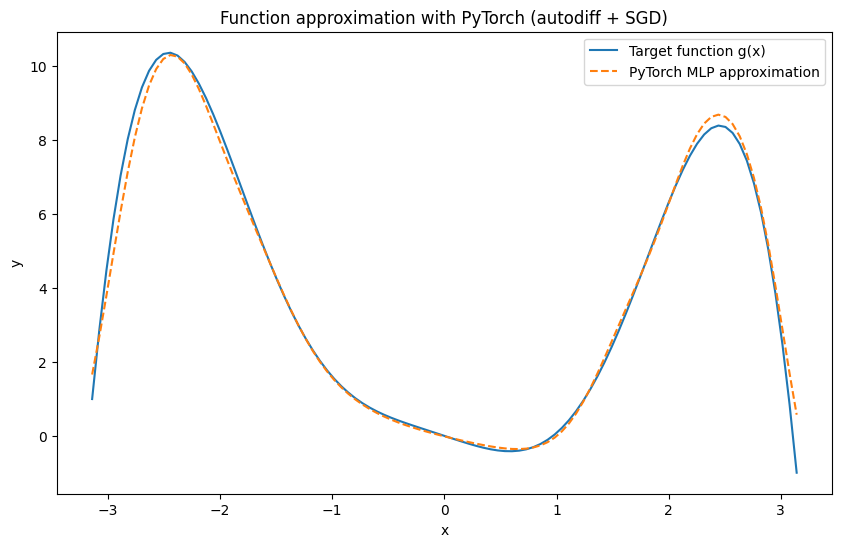

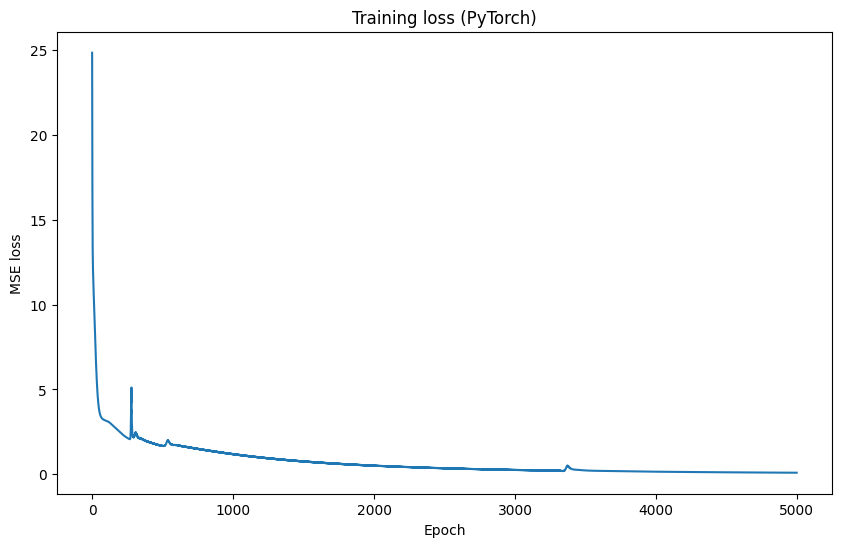

In [6]:
model.eval()
with torch.no_grad():
    y_pred = model(x_train).cpu().numpy()

plt.figure()
plt.plot(x_np, y_np, label="Target function g(x)")
plt.plot(x_np, y_pred, "--", label="PyTorch MLP approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Function approximation with PyTorch (autodiff + SGD)")
plt.legend()
plt.show()

plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training loss (PyTorch)")
plt.show()


## 6. Exercises
1. Replace full-batch training with mini-batches using `torch.utils.data.TensorDataset` and `DataLoader`.
2. Try `optim.Adam` and compare convergence.
3. Increase hidden size and observe overfitting/underfitting.
4. Add noise to the dataset and see what happens.
